In [1]:
import numpy as np
import operator
# from numpy.linalg import norm
from numpy.linalg import inv
from numpy.linalg import det
import math
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
plt.style.use('seaborn-whitegrid')
import time
import scipy as sp
import scipy.special
import scipy.misc
import scipy.integrate
import functools

%matplotlib widget

norm = lambda A: np.linalg.norm(A, ord=2)

### Решение уравнения теплопроводности

In [2]:
def draw(x_l, t_l, u_):
    fig, ax = plt.subplots(
        subplot_kw={"projection": "3d"}, figsize=(10, 10), dpi=80)
    
    X, T = np.meshgrid(x_l, t_l)
    Z = [[u_[j][i] for j in range(len(x_l))] for i in range(len(t_l))]
    ax.plot_surface(X, T, np.array(Z), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$t$', fontsize=20)
    ax.set_zlabel('$Temp$', fontsize=20)

In [3]:
def check_cond(k, tau, h):
    # проверка условия устойчивости
    assert 2 * k * tau <= h**2, "No stability!"


def explicit(u, max_x, max_t, k, f, t_seg, x_seg, suppress=False):
    # явная схема
    h = max_x / x_seg
    tau = max_t / t_seg

    if not suppress:
        check_cond(k, tau, h)

    x_l = np.linspace(0, max_x, x_seg + 1)
    t_l = np.linspace(0, max_t, t_seg + 1)

    @functools.lru_cache(maxsize=None)
    def approx_u(x, t):
        if x == 0:
            return u(0, t_l[t])
        if x == x_seg:
            return u(max_x, t_l[t])
        if t == 0:
            return u(x_l[x], 0)

        Lu = approx_u(x - 1, t - 1) - 2 * approx_u(x, t - 1) + approx_u(x + 1, t - 1)
        return (approx_u(x, t - 1) + tau * (k / h**2 * Lu + f(x_l[x], t_l[t])))

    u_ = np.array([[approx_u(j, i) for j in range(x_seg + 1)] for i in range(t_seg + 1)])
    draw(x_l, t_l, u_)

In [4]:
def implicit(u, max_x, max_t, k, f, t_seg, x_seg):
    # неявная схема, sigma = 1
    h = max_x / x_seg
    tau = max_t / t_seg

    x_l = np.linspace(0, max_x, x_seg + 1)
    t_l = np.linspace(0, max_t, t_seg + 1)

    # граничные условия
    u_ = np.zeros((x_seg + 1, x_seg + 1))
    for x in range(x_seg + 1):
        u_[x][0] = u(x_l[x], 0)
    for t in range(t_seg + 1):
        u_[0][t]     = u(0, t_l[t])
        u_[x_seg][t] = u(max_x, t_l[t])

    # заполняем слои
    for t in range(1, t_seg + 1):
        A = np.zeros((x_seg + 1, x_seg + 1))
        b = np.zeros(x_seg + 1)

        # строим слау
        for x in range(1, x_seg):
            A[x][x - 1] = tau * k / h**2
            A[x][x]     = (-2 * tau * k / h**2 - 1)
            A[x][x + 1] = tau * k / h**2

            b[x] = -u_[x][t - 1] - tau * f(x_l[x], t_l[t])

        A[0][0]  = -(tau * k / h + 1)
        A[0][1]  = tau * k / h
        b[0]     = -u_[0][t - 1] - tau * f(0, t_l[t])

        A[x_seg][x_seg]     = tau * k / h - 1
        A[x_seg][x_seg - 1] = - tau * k / h
        b[x_seg]            = -u_[x_seg][t - 1] - tau * f(max_x, t_l[t])

        # решение слау - следующий слой
        next_layer = np.linalg.solve(A, b)
        
        for e in range(1, x_seg):
            u_[e][t] = next_layer[e]
        
    draw(x_l, t_l, u_)

***
#### Тесты

### 1

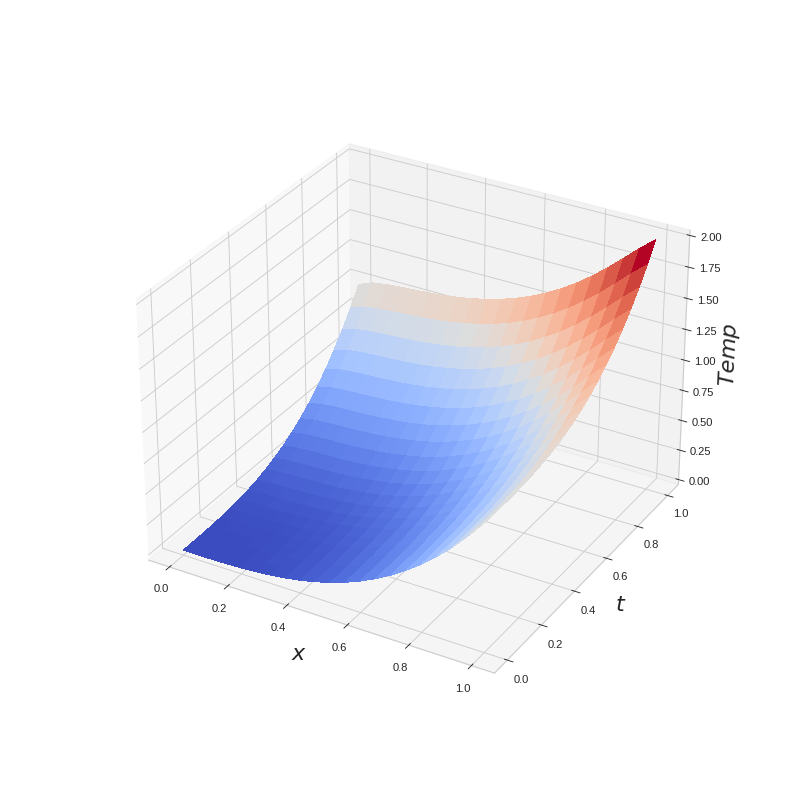

In [5]:
u = lambda x, t: x**3 + t**3
f = lambda x, t: 3 * t**2 - k *  6 * x

max_x = 1
max_t = 1
k = 0.01

implicit(u, max_x, max_t, k, f, 20, 20)

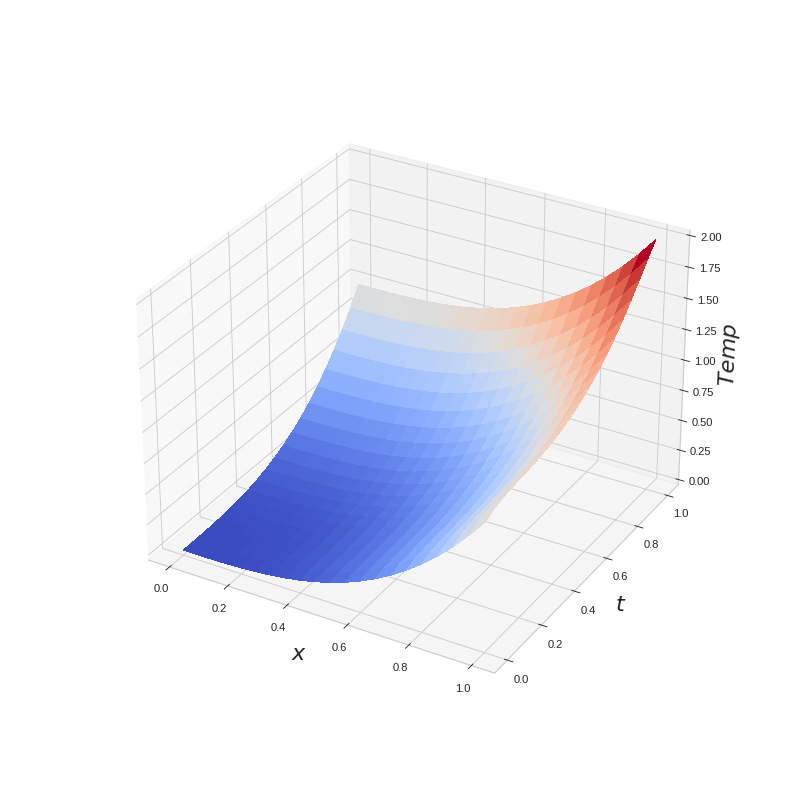

In [6]:
u = lambda x, t: x**3 + t**3
f = lambda x, t: 3 * t**2 - k *  6 * x

max_x = 1
max_t = 1
k = 0.01

explicit(u, max_x, max_t, k, f, 20, 20, suppress=False)

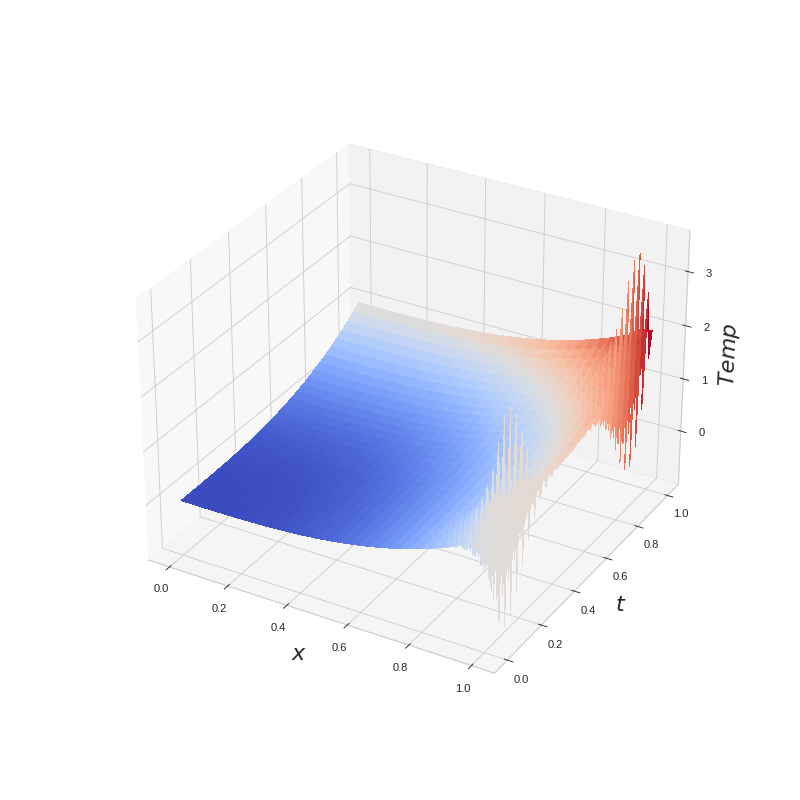

In [7]:
u = lambda x, t: x**3 + t**3
f = lambda x, t: 3 * t**2 - k *  6 * x

max_x = 1
max_t = 1
k = 0.01

explicit(u, max_x, max_t, k, f, 60, 60, suppress=True)

***
### 2

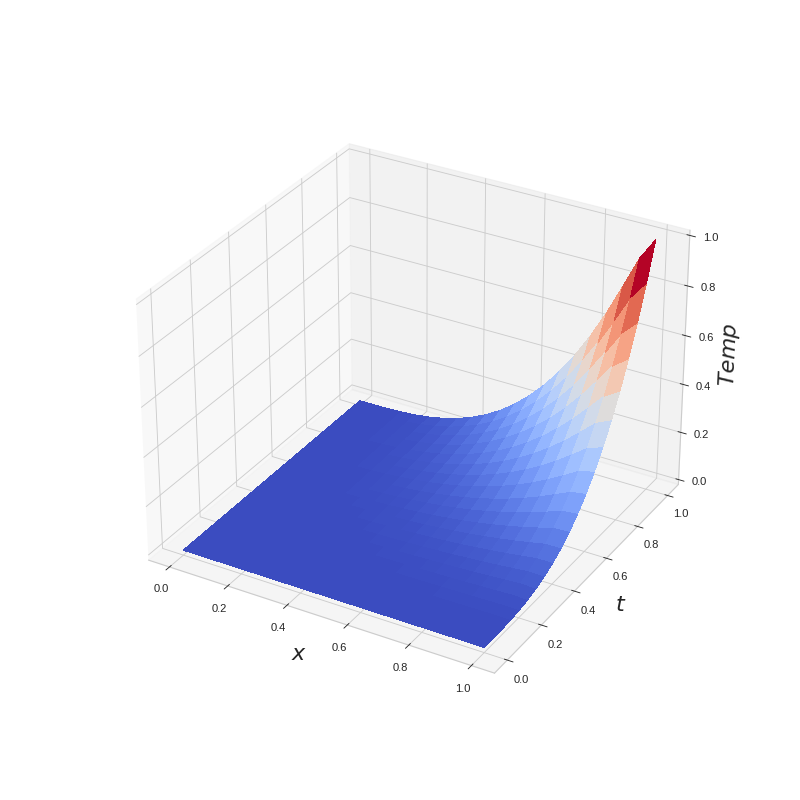

In [8]:
u = lambda x, t: x**3 * t**3
f = lambda x, t:  3 * t**2 * x**3 - k * 6 * x * t**3

max_x = 1
max_t = 1
k = 0.002

implicit(u, max_x, max_t, k, f, 20, 20)

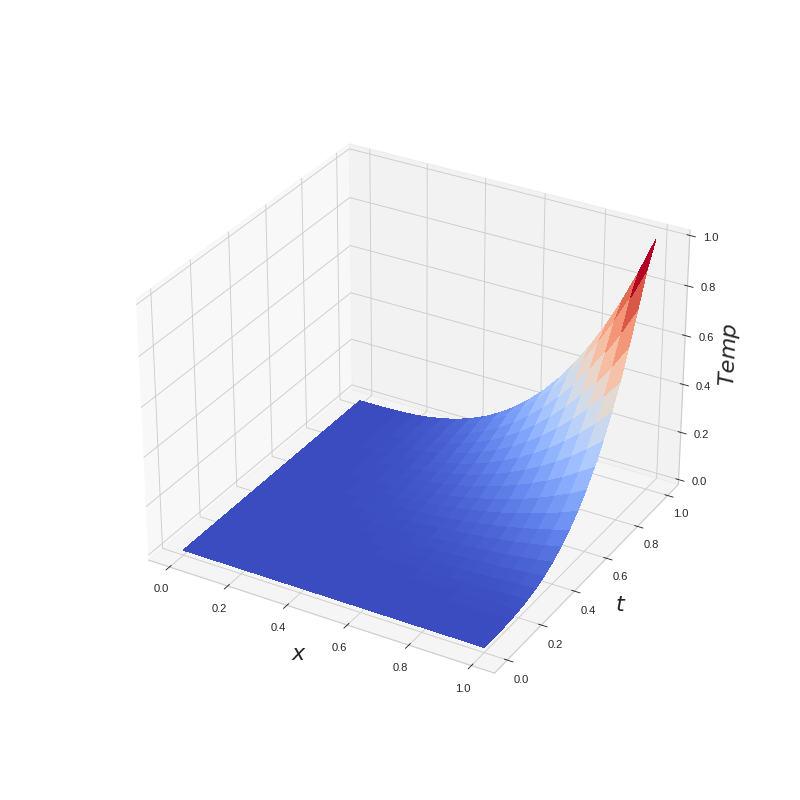

In [9]:
u = lambda x, t: x**3 * t**3
f = lambda x, t:  3 * t**2 * x**3 - k * 6 * x * t**3

max_x = 1
max_t = 1
k = 0.002

explicit(u, max_x, max_t, k, f, 20, 20, suppress=False)

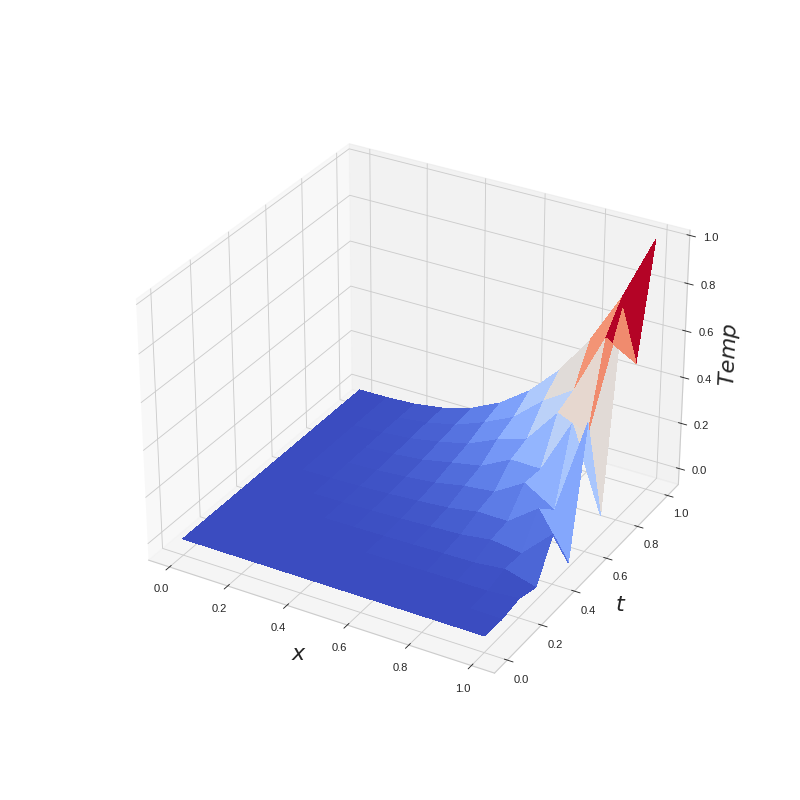

In [10]:
u = lambda x, t: x**3 * t**3
f = lambda x, t:  3 * t**2 * x**3 - k * 6 * x * t**3

max_x = 1
max_t = 1
k = 0.1

explicit(u, max_x, max_t, k, f, 10, 10, suppress=True)

### 3

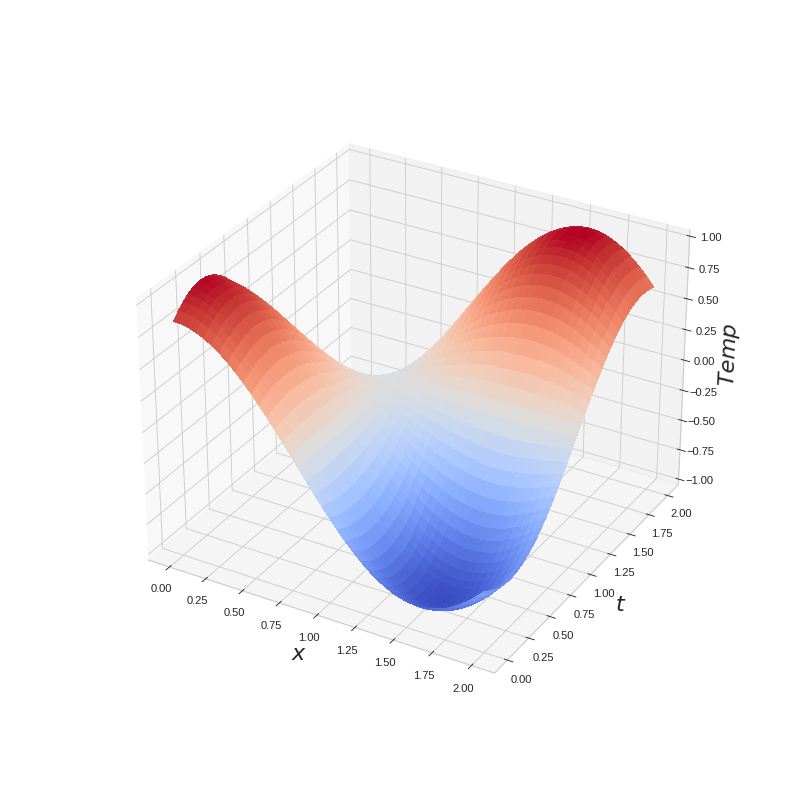

In [11]:
u = lambda x, t: np.sin(2 * t + 1) * np.cos(2 * x)
f = lambda x, t: np.cos(2 * t + 1) * 2 * np.cos(2 * x) - k * np.sin(2 * t + 1) * (-4 * np.cos(2 * x))

max_x = 2
max_t = 2
k = 0.00002

implicit(u, max_x, max_t, k, f, 200, 200)

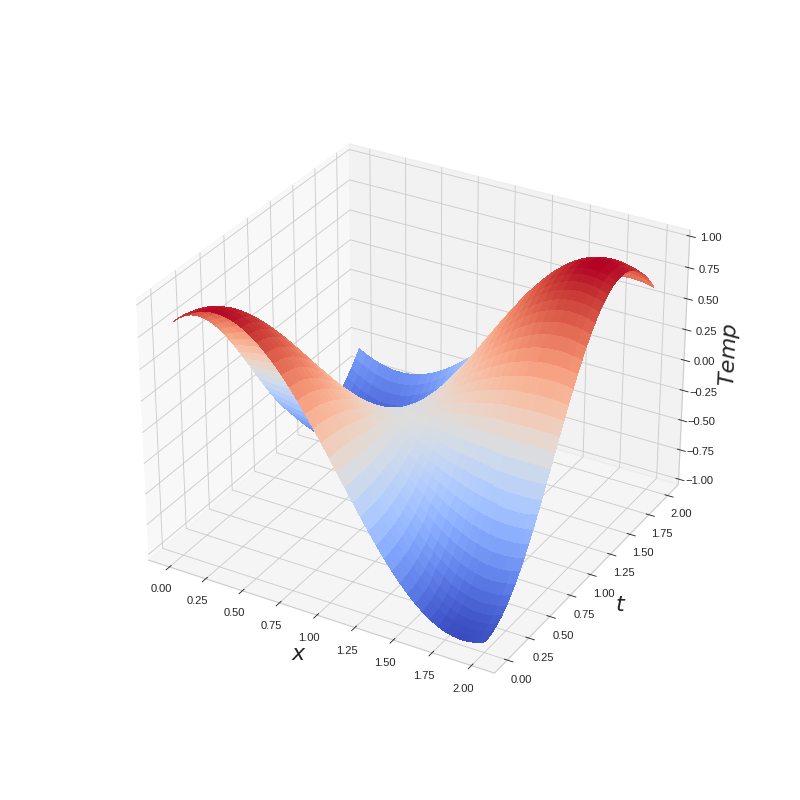

In [12]:
u = lambda x, t: np.sin(2 * t + 1) * np.cos(2 * x)
f = lambda x, t: np.cos(2 * t + 1) * 2 * np.cos(2 * x) - k * np.sin(2 * t + 1) * (-4 * np.cos(2 * x))

max_x = 2
max_t = 2
k = 0.00002

explicit(u, max_x, max_t, k, f, 200, 200)

/tmp/ipykernel_457271/3790163825.py:27: RuntimeWarning: overflow encountered in double_scalars
  return (approx_u(x, t - 1) + tau * (k / h**2 * Lu + f(x_l[x], t_l[t])))
/tmp/ipykernel_457271/3790163825.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return (approx_u(x, t - 1) + tau * (k / h**2 * Lu + f(x_l[x], t_l[t])))
/mnt/sdb1/university/6/calcs practices/hw/venv/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/mnt/sdb1/university/6/calcs practices/hw/venv/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


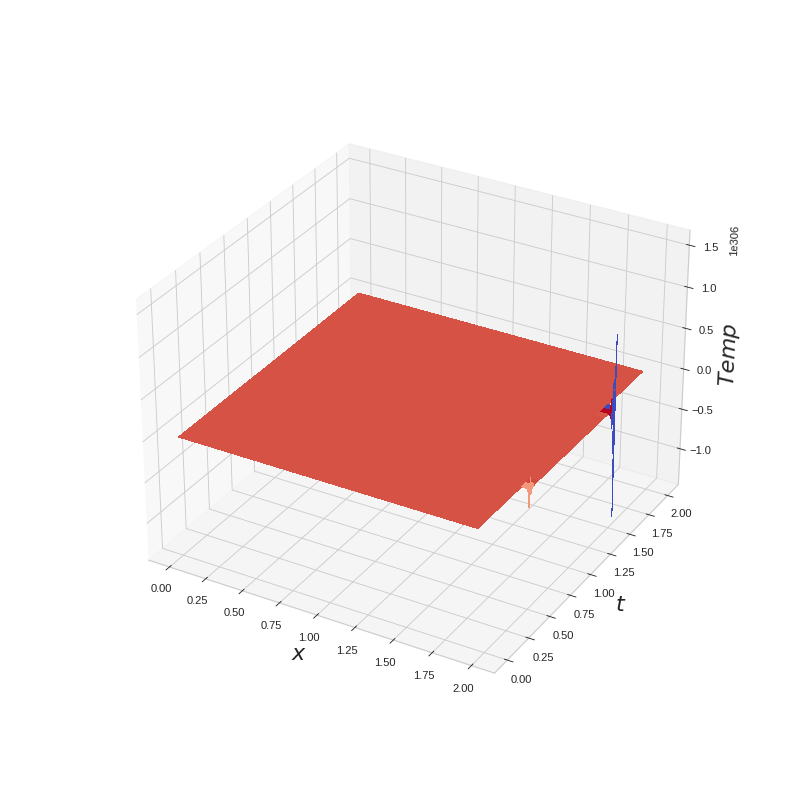

In [13]:
u = lambda x, t: np.sin(2 * t + 1) * np.cos(2 * x)
f = lambda x, t: np.cos(2 * t + 1) * 2 * np.cos(2 * x) - k * np.sin(2 * t + 1) * (-4 * np.cos(2 * x))

max_x = 2
max_t = 2
k = 0.1

explicit(u, max_x, max_t, k, f, 200, 200, suppress=True)

### 4

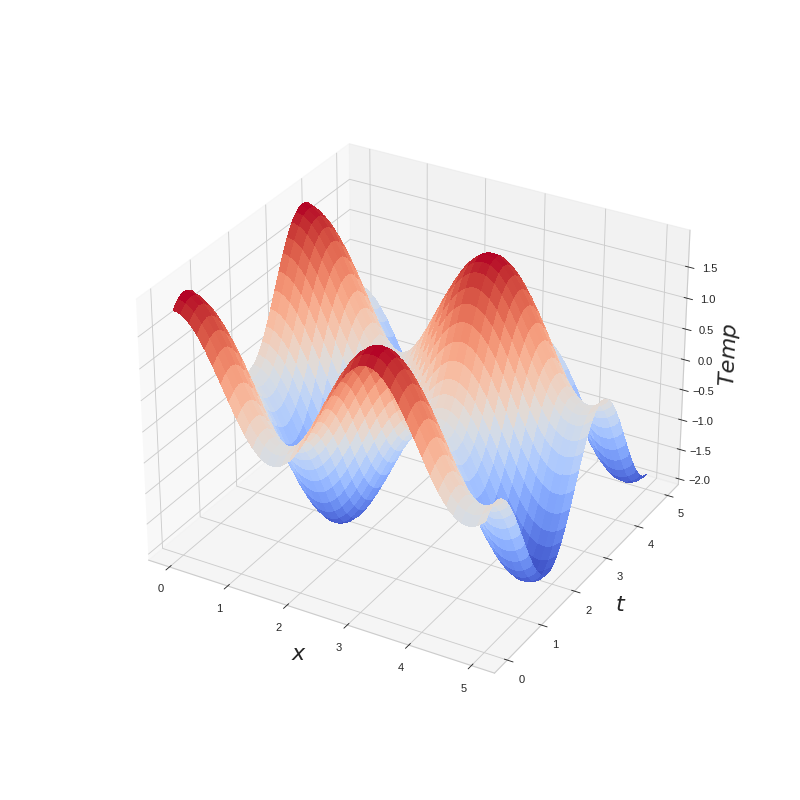

In [14]:
u = lambda x, t: np.sin(2 * t + 1) + np.cos(2 * x)
f = lambda x, t: np.cos(2 * t + 1) * 2 - k * (-4 * np.cos(2 * x))

max_x = 5
max_t = 5
k = 0.00002

implicit(u, max_x, max_t, k, f, 200, 200)

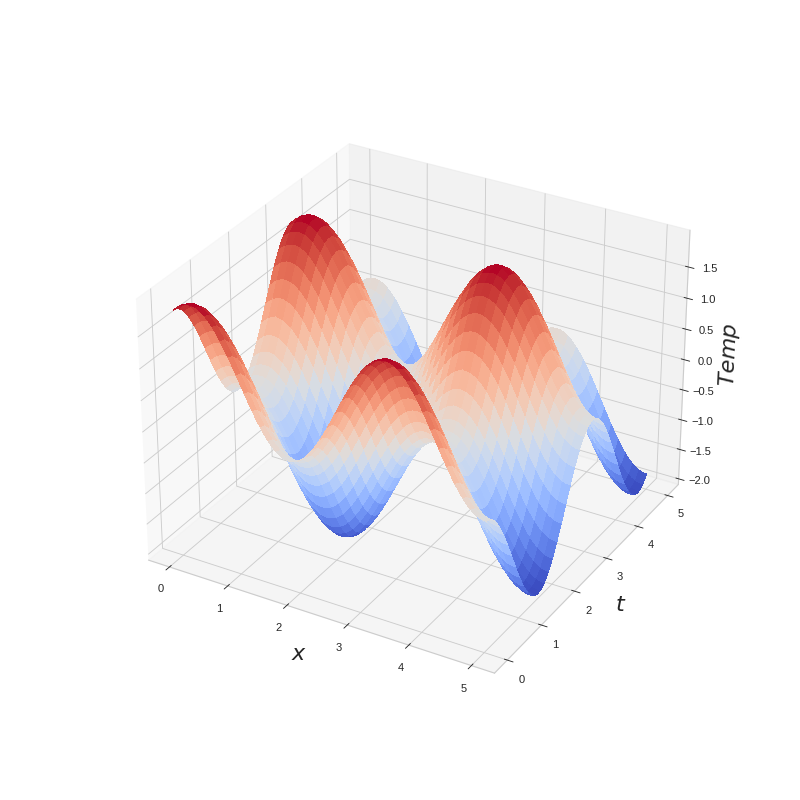

In [15]:
u = lambda x, t: np.sin(2 * t + 1) + np.cos(2 * x)
f = lambda x, t: np.cos(2 * t + 1) * 2 - k * (-4 * np.cos(2 * x))

max_x = 5
max_t = 5
k = 0.00002

explicit(u, max_x, max_t, k, f, 200, 200)